In [1]:
import sys
sys.path.append("/vol/bitbucket/ad6013/Research/gp-causal")
import numpy as np
import matplotlib.pyplot as plt

import pickle

In [2]:
file_2 = "/vol/bitbucket/ad6013/Research/gp-causal/results/fullscore-sim-2-gplvm-sqexp-reinit20.p"


with open(file_2, "rb") as f:
    results_2 = pickle.load(f)

In [3]:
file_1 = "/vol/bitbucket/ad6013/Research/gp-causal/results/fullscore-sim-gplvm-sqexp-reinit20.p"


with open(file_1, "rb") as f:
    results_1 = pickle.load(f)

In [4]:
# log odds will be causal hypothesis over anticausal
scores_1 = {}
for idx, i in enumerate(results_1['scores']):
    if idx > 49:
        break
    causal = i[0]
    anti_causal = i[1]
    scores_1[idx] = (causal, anti_causal)
    if sum(causal) > sum(anti_causal):
        print(idx)

1
8
9
10
11
13
15
18
23
25
31
33
38
39
46
48


In [5]:
# log odds will be causal hypothesis over anticausal
scores_2 = {}
for idx, i in enumerate(results_2[1]):
    idx += 50
    causal = i[0]
    anti_causal = i[1]
    scores_2[idx] = (causal, anti_causal)
    if sum(causal) > sum(anti_causal):
        print(idx)

55
58
63
71
74
76
84
87


In [6]:
file_3 = "/vol/bitbucket/ad6013/Research/gp-causal/results/fullscore-sim-gplvm-sqexp-reinit5-numind110.p"


with open(file_3, "rb") as f:
    results_3 = pickle.load(f)

In [7]:
wrong = [1,
    8,
    9,
    10,
    11,
    13,
    15,
    18,
    23,
    25,
    31,
    33,
    38,
    39,
    46,
    48,
    55,
    58,
    63,
    71,
    74,
    76,
    84,
    87]
scores_3 = {}
for idx, i in enumerate(results_3['scores']):
    causal = i[0]
    anti_causal = i[1]
    scores_3[wrong[idx]] = (causal, anti_causal)

In [8]:
if 50 in scores_2.keys():
    print(1)

1


In [9]:
final_scores = {}
all_log_diffs = {}
correct_idx = []
wrong_idx = []
for i in range(100):
    if i in scores_3.keys():
        causal_x_3 = scores_3[i][0][0]
        causal_y_x_3 = scores_3[i][0][1]
        anticausal_y_3 = scores_3[i][1][0]
        anticausal_x_y_3 = scores_3[i][1][1]
        compare = True
    else:
        compare = False 
    if i in scores_1.keys():
        causal_x = scores_1[i][0][0]
        causal_y_x = scores_1[i][0][1]
        anticausal_y = scores_1[i][1][0]
        anticausal_x_y = scores_1[i][1][1]
    elif i in scores_2.keys():
        causal_x = scores_2[i][0][0]
        causal_y_x = scores_2[i][0][1]
        anticausal_y = scores_2[i][1][0]
        anticausal_x_y = scores_2[i][1][1]
    else:
        raise ValueError(f"{i} not found in results!")
    if compare:
        final_causal_x = min(causal_x, causal_x_3)
        final_causal_y_x = min(causal_y_x, causal_y_x_3)
        final_anticausal_y = min(anticausal_y, anticausal_y_3)
        final_anticausal_x_y = min(anticausal_x_y, anticausal_x_y_3)
    else:
        final_causal_x = causal_x
        final_causal_y_x = causal_y_x
        final_anticausal_y = anticausal_y
        final_anticausal_x_y = anticausal_x_y
    final_scores[i] = (
        (final_causal_x, final_causal_y_x),
        (final_anticausal_y, final_anticausal_x_y)
    )
    score_causal = final_causal_x + final_causal_y_x
    score_anticausal = final_anticausal_y + final_anticausal_x_y
    log_diff = score_causal - score_anticausal
    all_log_diffs[i] = log_diff
    if log_diff < 0:
        correct_idx.append(i)
    elif log_diff > 0:
        wrong_idx.append(i)
    else:
        print(
            f"Undecided: {i}"
        )


In [10]:
wrong_idx

[1, 8, 9, 10, 11, 13, 15, 23, 25, 31, 33, 38, 39, 55, 58, 71, 74, 76, 84, 87]

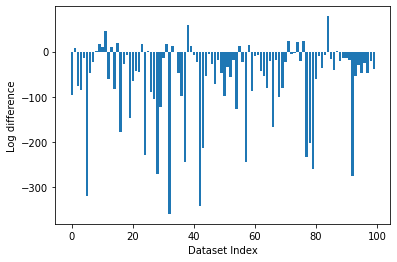

In [11]:
plt.bar(np.arange(len(all_log_diffs)), list(all_log_diffs.values()))
plt.ylabel("Log difference")
plt.xlabel("Dataset Index")
# plt.ylim(-400, 200)
plt.show()

In [12]:
# Calculate ROC curve and AUC 
# The score value should be - causal + anticausal
# This is because a higher score should mean causal and a lower score mean anticausal

# We also need to ensure half the labels are anticausal and half the labels are causal
# We thus need to generate indexes that will be the anticausal direction is true
# then for the other ones, we will multiply the scores by -1

anticausal_labels = np.random.choice(100, 50, replace=False)
causal_labels = np.array(
    list(
        set(np.arange(100)) - set(anticausal_labels)
    )
)
y_labels = np.zeros(100)
y_scores = np.zeros(100)
for i in range(100):
    if i in anticausal_labels:
        y_labels[i] = -1
        y_scores[i] = all_log_diffs[i]
    elif i in causal_labels:
        y_labels[i] = 1
        y_scores[i] = -1 * all_log_diffs[i]
    else:
        raise ValueError(f"Missed {i}")
    

In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_curve, auc


fpr, tpr, _ = roc_curve(y_labels, y_scores)
roc_auc = auc(fpr, tpr)

In [14]:
roc_auc

0.8996000000000001

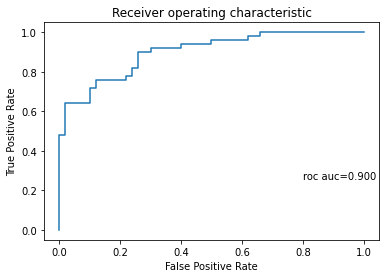

In [15]:
textstr = 'roc auc=%.3f\n'%(
    roc_auc
)
plt.text(0.8, 0.2, textstr, fontsize=10)
plt.plot(
    fpr, tpr
)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.show()

In [16]:
file = "/vol/bitbucket/ad6013/Research/gp-causal/results/fullscore-cep-gplvm-sqexp-reinit20.p"


with open(file, "rb") as f:
    results_tub = pickle.load(f)

In [17]:
corr, wrong, weight = results_tub["correct_idx"], results_tub["wrong_idx"], results_tub["weight"]
correct_weight = [weight[i] for i in corr]
wrong_weight = [weight[i] for i in wrong]
accuracy = np.sum(correct_weight) / (np.sum(correct_weight) + np.sum(wrong_weight))
print(f"\n Final accuracy: {accuracy}")


 Final accuracy: 0.6751023446222553


In [18]:
# log odds will be causal hypothesis over anticausal
log_odds_tub = []
for i in results_tub['scores']:
    causal = sum(i[0])
    anti_causal = sum(i[1])
    log_odds_tub.append(causal - anti_causal)

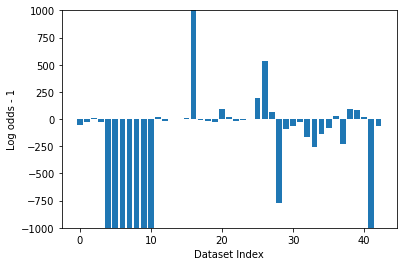

In [19]:
plt.bar(np.arange(len(log_odds_tub)), log_odds_tub)
plt.ylabel("Log odds - 1")
plt.xlabel("Dataset Index")
plt.ylim(-1000, 1000)
plt.show()

In [20]:
for idx, i in enumerate(log_odds_tub):
    print(
        f"{idx}, {i}"
    )


0, -58.76775580368246
1, -29.271284992371648
2, 5.444958032654995
3, -24.85126765075836
4, -6793.200733946684
5, -6791.042361109217
6, -3204.7850324804203
7, -3039.4245472529383
8, -3259.47271836702
9, -3258.417519880637
10, -3277.7193443540273
11, 18.309072591539007
12, -15.191325387190204
13, -3.0585648516163246
14, 3.348652760825644
15, 6.62747247219977
16, 9238.280529292864
17, -9.94984516822285
18, -15.494050632047674
19, -28.30637239151281
20, 94.65895082761631
21, 19.0851542336718
22, -21.773354030336804
23, -5.973443867824244
24, -2.655142919832997
25, 189.74702789557068
26, 529.873469576683
27, 66.12003965087115
28, -772.5473983240859
29, -90.46507534479179
30, -66.35001801947374
31, -23.445595758407535
32, -163.42221462529005
33, -256.4222602284218
34, -139.66086704732038
35, -78.10410591123707
36, 30.30972383912308
37, -230.4034228531914
38, 90.78074737329052
39, 84.92132219471614
40, 22.14295212223078
41, -1203.1253068311053
42, -66.21195299151259


In [21]:
Correct: 40, Wrong: 17
Correct: 42, Wrong: 8

SyntaxError: invalid syntax (300375016.py, line 1)

In [ ]:
wrong_idx

[1,
 8,
 9,
 10,
 11,
 13,
 15,
 18,
 23,
 25,
 31,
 33,
 38,
 39,
 46,
 48,
 53,
 55,
 62,
 63,
 74,
 78,
 80,
 81,
 82,
 84,
 93,
 96]

Load cause-effect pairs: 100%|██████████| 100/100 [00:00<00:00, 387.74it/s]



 1: 7.947008861534641


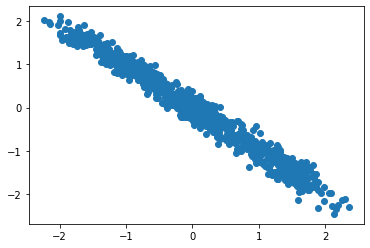


 8: 2.125546451411992


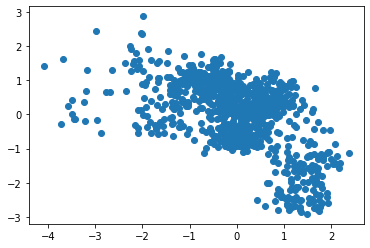


 9: 16.788658202864553


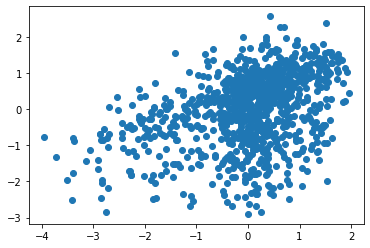


 10: 10.139711391789888


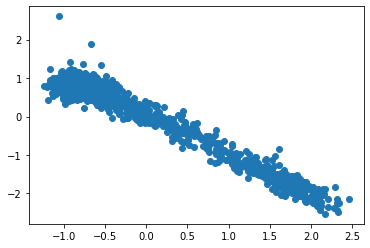


 11: 45.089589420741504


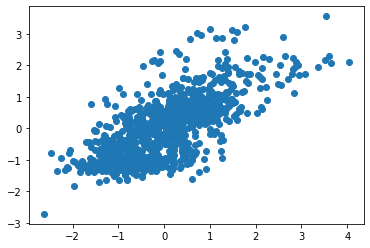


 13: 10.884235865943992


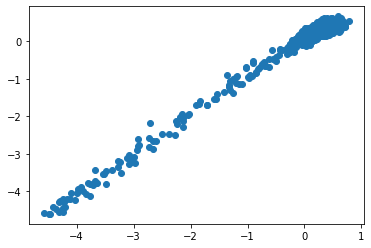


 15: 18.898060491425667


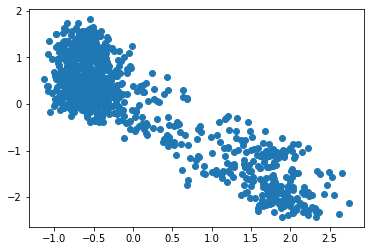


 23: 16.997171716323237


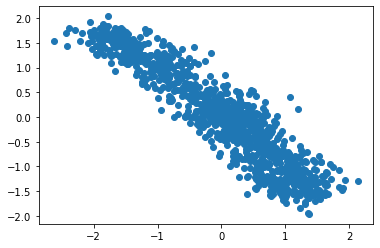


 25: 0.3289264679892767


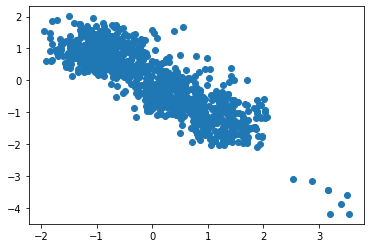


 31: 16.01142022572776


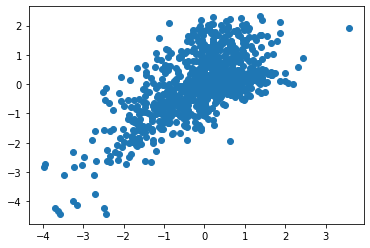


 33: 12.203888514887922


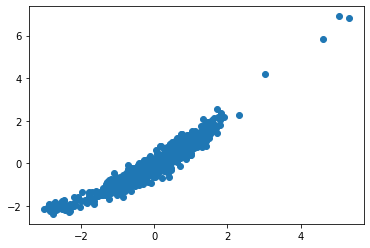


 38: 58.6196489362797


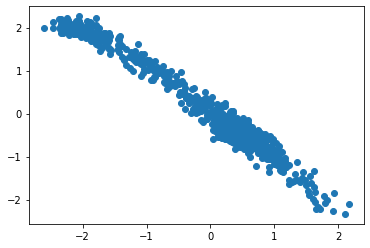


 39: 12.681931798781761


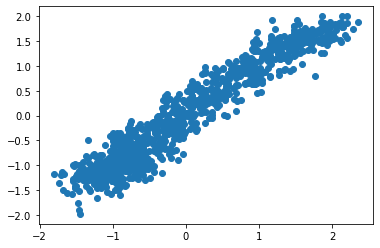


 55: 13.092166779384797


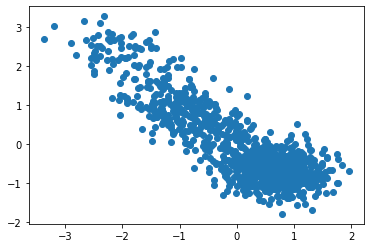


 58: 14.075042705045234


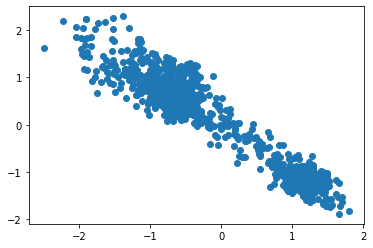


 71: 22.810219311423452


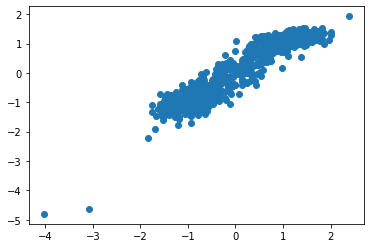


 74: 20.271401595046882


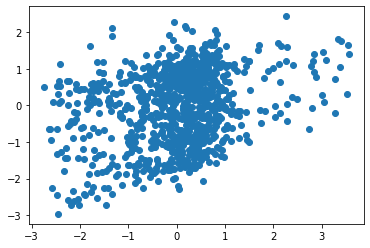


 76: 24.068180483076503


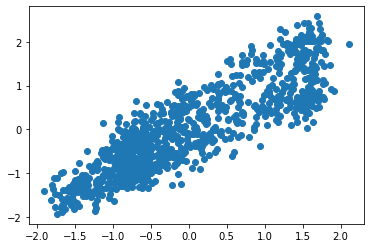


 84: 78.07925873321528


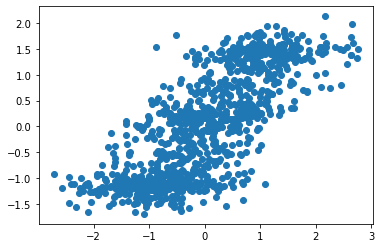


 87: 0.6112850384004105


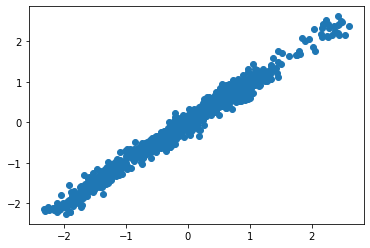

In [ ]:
# Plot the results that we got wrong
from data.get_data import get_simulated_pairs_dataset


x, y, weight = get_simulated_pairs_dataset(
    data_path='/vol/bitbucket/ad6013/Research/gp-causal/data/sim_pairs/files'
)

for i in range(100):
    if i in wrong_idx:
        input, output = x[i], y[i]
        input = (input - input.mean(axis=0)[:, None]) / input.std(axis=0)[:, None]
        output = (output - output.mean(axis=0)[:, None]) / output.std(axis=0)[:, None]
        print(f"\n {i}: {all_log_diffs[i]}")
        plt.scatter(input[:, 0], output[:, 0])
        plt.show()

# Cha pairs results analysis

In [1]:
import sys
sys.path.append("/vol/bitbucket/ad6013/Research/gp-causal")

In [2]:
import pickle 
import matplotlib.pyplot as plt
import numpy as np


work_dir = "/vol/bitbucket/ad6013/Research/gp-causal"
file = "fullscore-cha_pairs-gplvm-reinit20-numind200_start:0_end:150.p"
file_2 = "fullscore-cha_pairs-gplvm-reinit20-numind200_start:150_end:300.p"

In [3]:
with open(f"{work_dir}/results/{file}", "rb") as f:
    results = pickle.load(f)
with open(f"{work_dir}/results/{file_2}", "rb") as f:
    results_2 = pickle.load(f)

In [4]:
from data.get_data import get_cha_pairs_dataset


x, y, weight, target = get_cha_pairs_dataset(data_path=f"{work_dir}/data/cha_pairs/files")

In [5]:
num_runs_1 = len(results['scores'])
num_runs_2 = len(results_2['scores'])
all_bfgs_cha_scores = {} 

y_labels = np.zeros(num_runs_1 + num_runs_2)
y_scores = np.zeros(num_runs_1 + num_runs_2)
# causal labels are 1 thus we need to multiply all scores by -1
for i in range(num_runs_1):
    y_label_i = target[i][0]
    y_labels[i] = y_label_i
    # Calculate the score
    # This is a tuple
    scores = results['scores'][i]
    all_bfgs_cha_scores[i] = scores
    causal = sum(scores[0])
    anti_causal = sum(scores[1])
    final_score = - causal + anti_causal
    y_scores[i] = final_score
for i in range(150, 150 + num_runs_2):
    idx = i - 150 + num_runs_1
    y_label_i = target[i][0]
    y_labels[idx] = y_label_i
    # Calculate the score
    # This is a tuple
    scores = results_2['scores'][i - 150]
    all_bfgs_cha_scores[i] = scores
    causal = sum(scores[0])
    anti_causal = sum(scores[1])
    final_score = - causal + anti_causal
    y_scores[idx] = final_score


In [6]:
all_bfgs_cha_scores

{0: ((1242.492654092228, 937.3501643937325),
  (1780.3206693268194, 753.9405411568187)),
 1: ((2031.1930289197403, 904.4779723806632),
  (1928.3609430310416, 1331.9226789242061)),
 2: ((-326.9013134432871, 823.0228547304041),
  (1429.2542140075684, -566.6910731178982)),
 3: ((2101.7764262818077, 1389.2842684029029),
  (1978.4641966949716, 1529.1811871280615)),
 4: ((1835.2166618797532, 1743.2124819958062),
  (2011.1072484509946, 1602.8898671362713)),
 5: ((1001.9551462567379, 1771.2707650402003),
  (2128.407821316394, 591.6732755591471)),
 6: ((1277.6712558473037, 390.1837661319769),
  (1293.014945764915, 248.27267755270225)),
 7: ((488.9657024606595, 1296.8305555300494),
  (1641.8118234479625, 27.620153308060253)),
 8: ((2128.407837799411, 1327.5956549511181),
  (1852.4164772935492, 1636.3505945186316)),
 9: ((-2141.77000315476, 731.5536137146754),
  (1526.9336081234287, -2763.6095705462035)),
 10: ((2119.0352693968116, 1610.0694405430772),
  (2128.4078260825663, 1588.1627427802014)),

In [7]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


fpr, tpr, _ = roc_curve(y_labels, y_scores)
roc_auc = auc(fpr, tpr)


In [8]:
roc_auc

0.8208676307007786

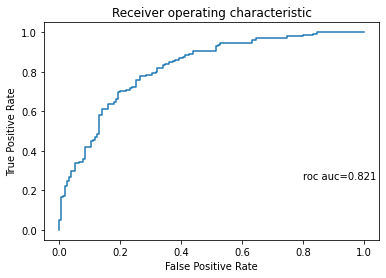

In [9]:
textstr = 'roc auc=%.3f\n'%(
    roc_auc
)
plt.text(0.8, 0.2, textstr, fontsize=10)
plt.plot(
    fpr, tpr
)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.show()

# Gauss pairs results analysis

In [1]:
import sys
sys.path.append("/vol/bitbucket/ad6013/Research/gp-causal")

In [2]:
from data import get_data

In [3]:
data_name = "gauss"

In [4]:
import pickle 
import matplotlib.pyplot as plt
import numpy as np



work_dir = "/vol/bitbucket/ad6013/Research/gp-causal"
file_1 = f"fullscore-{data_name}_pairs-gplvm-reinit15-numind200_start:0_end:20.p"
file_2 = f"fullscore-{data_name}_pairs-gplvm-reinit15-numind200_start:20_end:40.p"
file_3 = f"fullscore-{data_name}_pairs-gplvm-reinit15-numind200_start:40_end:60.p"
file_4 = f"fullscore-{data_name}_pairs-gplvm-reinit15-numind200_start:60_end:80.p"
file_5 = f"fullscore-{data_name}_pairs-gplvm-reinit15-numind200_start:80_end:100.p"
file_6 = f"fullscore-{data_name}_pairs-gplvm-reinit15-numind200_start:100_end:120.p"
file_7 = f"fullscore-{data_name}_pairs-gplvm-reinit15-numind200_start:120_end:140.p"
file_8 = f"fullscore-{data_name}_pairs-gplvm-reinit15-numind200_start:140_end:160.p"
file_9 = f"fullscore-{data_name}_pairs-gplvm-reinit15-numind200_start:160_end:180.p"
file_10 = f"fullscore-{data_name}_pairs-gplvm-reinit15-numind200_start:180_end:200.p"
file_11 = f"fullscore-{data_name}_pairs-gplvm-reinit15-numind200_start:200_end:220.p"
file_12 = f"fullscore-{data_name}_pairs-gplvm-reinit15-numind200_start:220_end:240.p"
file_13 = f"fullscore-{data_name}_pairs-gplvm-reinit15-numind200_start:240_end:260.p"
file_14 = f"fullscore-{data_name}_pairs-gplvm-reinit15-numind200_start:260_end:280.p"
file_15 = f"fullscore-{data_name}_pairs-gplvm-reinit15-numind200_start:280_end:300.p"

In [5]:
import importlib
from data import get_data

data_get = getattr(get_data, f"get_{data_name}_pairs_dataset")

x, y, weight, target = data_get(data_path=f"{work_dir}/data/{data_name}_pairs/files")

In [6]:
target[23]

array([-1.])

In [7]:
y_labels = []
y_scores = []
wrong_idx = []
all_bfgs_scores = {}
all_causal_scores = {}

for file_idx in range(15):
    with open(f"{work_dir}/results/{eval(f'file_{file_idx + 1}')}", "rb") as f:
        results = pickle.load(f)
        wrong_idx.extend(results['wrong_idx'])
    for i in range(len(results['scores'])):
        idx = 20 * file_idx + i
        y_label_i = target[idx][0]
        y_labels.append(y_label_i)
        # Calculate the score
        # This is a tuple
        scores = results['scores'][i]
        causal = sum(scores[0])
        anti_causal = sum(scores[1])
        final_score = - causal + anti_causal
        y_scores.append(final_score)
        all_bfgs_scores[idx] = scores 
        all_causal_scores[idx] = y_label_i * final_score

In [8]:
all_bfgs_scores

{0: ((2128.4079357801097, 1160.9584729626072),
  (2128.4079177564927, 1148.8441007556053)),
 1: ((570.5029303694982, 1838.5080812583305),
  (2112.0079350690785, 581.5357280249145)),
 2: ((2005.6714134139438, 322.64773057966295),
  (1501.555871951638, 546.9320689105443)),
 3: ((1819.4497481719136, 608.2333043549193),
  (1892.6395010825818, 552.439159792629)),
 4: ((1242.8735242093126, 1198.2045750654647),
  (1915.3308090512528, 571.6831286395068)),
 5: ((1960.4407938226982, 284.7453379466533),
  (1220.6307810084672, 942.7014542153915)),
 6: ((1619.4647361399934, 81.01374551595927),
  (1686.342960562435, -30.30017157924101)),
 7: ((2023.1576764056945, 1480.8627404514066),
  (2112.08974985749, 1385.5088047538443)),
 8: ((2111.8060585322683, 974.3148725110157),
  (1714.4824570423175, 1275.9035525595136)),
 9: ((2088.1687842534943, 1252.8519496096396),
  (1910.274654705166, 1382.327460948436)),
 10: ((2119.62332127621, 1675.563275190952),
  (2062.9309512384025, 1725.2981371568299)),
 11: ((

In [9]:
all_bfgs_scores

{0: ((2128.4079357801097, 1160.9584729626072),
  (2128.4079177564927, 1148.8441007556053)),
 1: ((570.5029303694982, 1838.5080812583305),
  (2112.0079350690785, 581.5357280249145)),
 2: ((2005.6714134139438, 322.64773057966295),
  (1501.555871951638, 546.9320689105443)),
 3: ((1819.4497481719136, 608.2333043549193),
  (1892.6395010825818, 552.439159792629)),
 4: ((1242.8735242093126, 1198.2045750654647),
  (1915.3308090512528, 571.6831286395068)),
 5: ((1960.4407938226982, 284.7453379466533),
  (1220.6307810084672, 942.7014542153915)),
 6: ((1619.4647361399934, 81.01374551595927),
  (1686.342960562435, -30.30017157924101)),
 7: ((2023.1576764056945, 1480.8627404514066),
  (2112.08974985749, 1385.5088047538443)),
 8: ((2111.8060585322683, 974.3148725110157),
  (1714.4824570423175, 1275.9035525595136)),
 9: ((2088.1687842534943, 1252.8519496096396),
  (1910.274654705166, 1382.327460948436)),
 10: ((2119.62332127621, 1675.563275190952),
  (2062.9309512384025, 1725.2981371568299)),
 11: ((

In [10]:
all_causal_scores

{0: -12.114390230618937,
 1: 284.5326514661642,
 2: 279.83120313142445,
 3: 17.395608348377664,
 4: 45.93583841598229,
 5: 81.85389654549272,
 6: 44.435692672758705,
 7: -6.421862245766533,
 8: 95.73492144145303,
 9: -48.418618209531815,
 10: 6.957508071929624,
 11: 77.66285510796433,
 12: -26.891980110673103,
 13: 35.189141533139264,
 14: 95.41821323115573,
 15: 0.3408355943638526,
 16: 143.4195481911056,
 17: 218.4393868578777,
 18: 5.054548218216951,
 19: 109.78907114075992,
 20: 28.697208362958918,
 21: 44.262314822859935,
 22: 63.6230415701375,
 23: -58.962321215669135,
 24: -35.6107753167862,
 25: 107.76747841372617,
 26: 35.40911693886028,
 27: 89.02076599027805,
 28: 11.00014171911289,
 29: 50.79858638035694,
 30: -13.024627371521547,
 31: 368.2460493501035,
 32: 35.98769736096983,
 33: 75.30338155099298,
 34: -12.61936242465572,
 35: 25.49257089349294,
 36: 43.28685592235661,
 37: 45.90899259196067,
 38: 130.53170076988317,
 39: -33.39503614159571,
 40: 340.5447087377488,
 41:

In [11]:
all_causal_scores

{0: -12.114390230618937,
 1: 284.5326514661642,
 2: 279.83120313142445,
 3: 17.395608348377664,
 4: 45.93583841598229,
 5: 81.85389654549272,
 6: 44.435692672758705,
 7: -6.421862245766533,
 8: 95.73492144145303,
 9: -48.418618209531815,
 10: 6.957508071929624,
 11: 77.66285510796433,
 12: -26.891980110673103,
 13: 35.189141533139264,
 14: 95.41821323115573,
 15: 0.3408355943638526,
 16: 143.4195481911056,
 17: 218.4393868578777,
 18: 5.054548218216951,
 19: 109.78907114075992,
 20: 28.697208362958918,
 21: 44.262314822859935,
 22: 63.6230415701375,
 23: -58.962321215669135,
 24: -35.6107753167862,
 25: 107.76747841372617,
 26: 35.40911693886028,
 27: 89.02076599027805,
 28: 11.00014171911289,
 29: 50.79858638035694,
 30: -13.024627371521547,
 31: 368.2460493501035,
 32: 35.98769736096983,
 33: 75.30338155099298,
 34: -12.61936242465572,
 35: 25.49257089349294,
 36: 43.28685592235661,
 37: 45.90899259196067,
 38: 130.53170076988317,
 39: -33.39503614159571,
 40: 340.5447087377488,
 41:

In [12]:
len(y_labels)

230

In [13]:
y_labels = np.array(y_labels)
y_scores = np.array(y_scores)

In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_curve, auc


fpr, tpr, _ = roc_curve(y_labels, y_scores)
roc_auc = auc(fpr, tpr)

In [15]:
roc_auc

0.891158006202254

In [17]:
from sklearn.metrics import roc_auc_score
roc_auc = (roc_auc_score(y_labels == 1, y_scores) + roc_auc_score(y_labels == -1, - y_scores)) / 2
roc_auc

0.8879551820728291

In [17]:
(roc_auc_score(y_labels == 1, y_scores))

0.8906734291349676

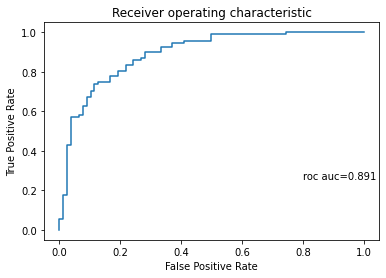

In [18]:
textstr = 'roc auc=%.3f\n'%(
    roc_auc
)
plt.text(0.8, 0.2, textstr, fontsize=10)
plt.plot(
    fpr, tpr
)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.show()

In [18]:
all_causal_scores

{0: -12.68425835918697,
 1: 283.66388346759413,
 2: 279.8476986515152,
 3: 17.577488871721016,
 4: 45.340885283092575,
 5: 81.93375392412463,
 6: 44.638960178882826,
 7: -6.422488230791259,
 8: 97.74280964908849,
 9: -48.42243418328917,
 10: 20.446617080508986,
 11: 76.97101016803254,
 12: -26.896723144976477,
 13: 35.17496838922011,
 14: -107.17345823334881,
 15: -3.205253318200903,
 16: 139.86758125222832,
 17: -54.804017083491544,
 18: 8.372630974757158,
 19: 112.8287343604602,
 20: 28.689118275823148,
 21: 44.13020776931489,
 22: 63.44613363648568,
 23: -58.97277551197271,
 24: -35.58490640541686,
 25: 106.28988389687629,
 26: 34.007724641342975,
 27: 89.04641620704297,
 28: 11.264985118337336,
 29: 50.80291535373499,
 30: -13.60582368835503,
 31: 368.74059553340976,
 32: 35.98882018755785,
 33: 74.20011921222181,
 34: -14.814864687527006,
 35: 25.505219568277425,
 36: -78.49989121017143,
 37: 45.846401306177086,
 38: 131.68212523652483,
 39: -33.39772497298827,
 40: 342.4080763421

In [18]:
all_bfgs_scores

{0: ((2128.407857868433, 1161.0878201043197),
  (2128.4078116252413, 1148.4036079883244)),
 1: ((570.5971714916177, 1838.5358821425198),
  (2112.0086279249554, 580.7883091767762)),
 2: ((2005.6700882446257, 322.6656308062661),
  (1501.5561124811306, 546.9319079182459)),
 3: ((1818.9317943955566, 608.2462765807238),
  (1892.3150285955735, 552.4405312524282)),
 4: ((1242.8962607426438, 1198.644474791121),
  (1915.2626741640383, 571.618946652819)),
 5: ((1960.4431778792696, 284.74672856934285),
  (1220.5994948699245, 942.6566576545633)),
 6: ((1619.4635750043549, 81.01549898760186),
  (1686.3509386314536, -30.510824818379774)),
 7: ((2023.1581160308178, 1480.8638876358823),
  (2112.0899607198558, 1385.5095547160531)),
 8: ((2111.807490240761, 974.3174307300137),
  (1714.4528111335503, 1273.929300188136)),
 9: ((2088.168792159807, 1252.853572184294),
  (1910.2712065961941, 1382.3287235646176)),
 10: ((2128.4078705678344, 1675.5651575881989),
  (2062.9305273472696, 1720.5958837282549)),
 11

In [19]:
wrong_idx

[0,
 7,
 9,
 12,
 14,
 15,
 17,
 23,
 24,
 30,
 34,
 36,
 39,
 41,
 42,
 43,
 48,
 56,
 59,
 60,
 62,
 67,
 72,
 73,
 75,
 77,
 78,
 83,
 84,
 117,
 122,
 125,
 128,
 130,
 138,
 139,
 144,
 145,
 156,
 161,
 164,
 165,
 169,
 171,
 172,
 179,
 184,
 188,
 194,
 200,
 203,
 204,
 208,
 209,
 217,
 218,
 219,
 224,
 227,
 235,
 242,
 244,
 246,
 247,
 253,
 254,
 257,
 258,
 266,
 274,
 285,
 288,
 299]

0


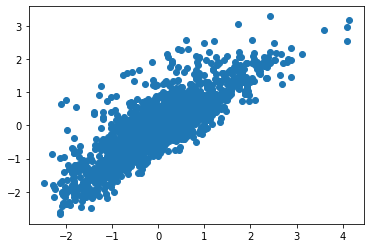

7


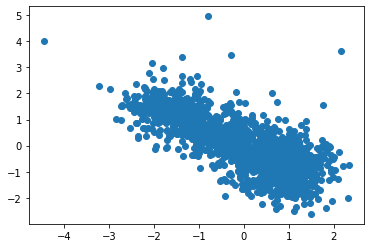

9


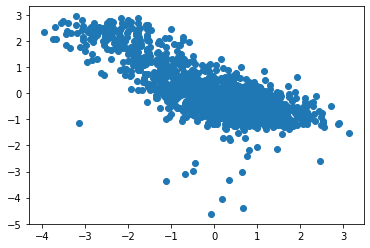

12


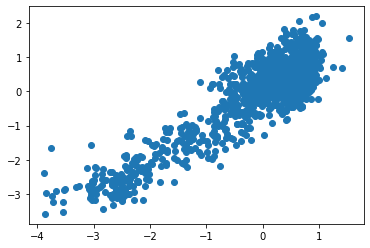

14


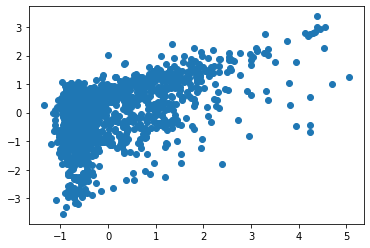

15


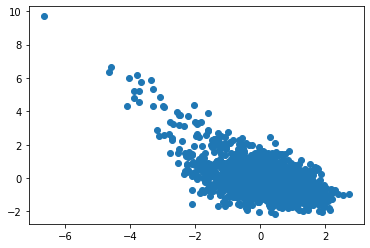

17


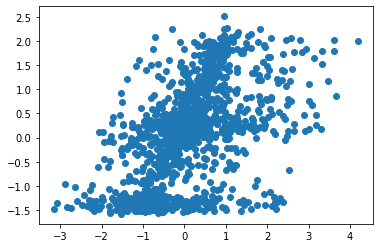

23


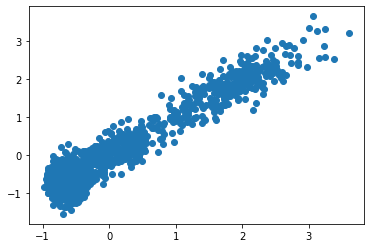

24


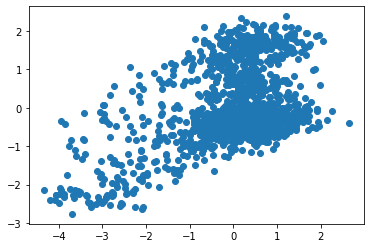

30


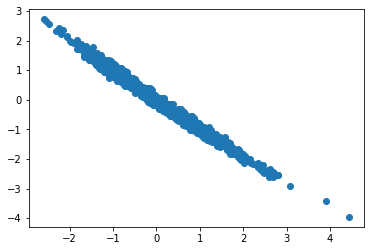

34


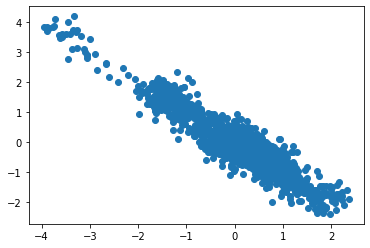

36


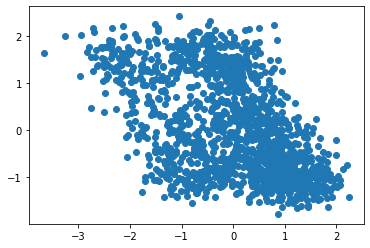

39


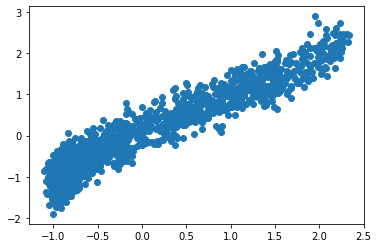

41


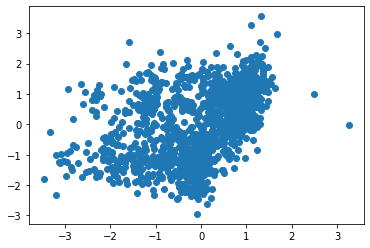

42


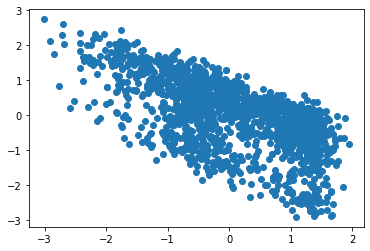

43


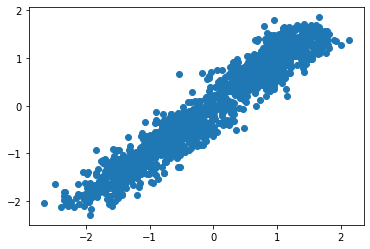

48


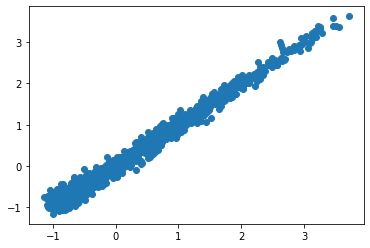

56


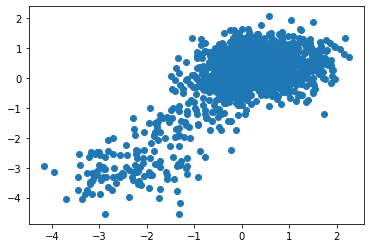

59


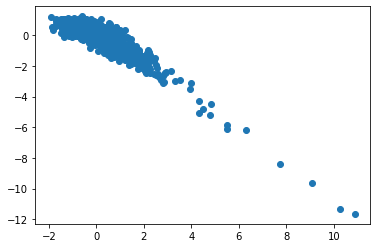

60


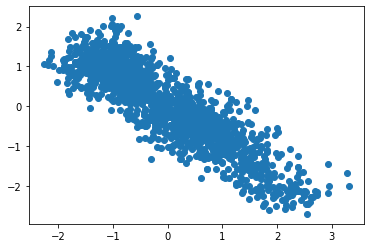

62


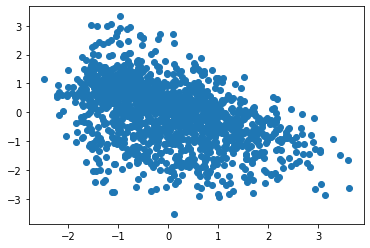

67


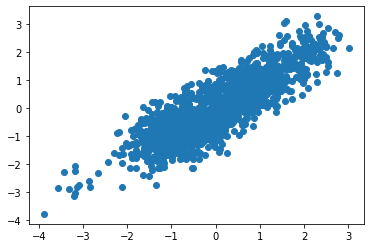

72


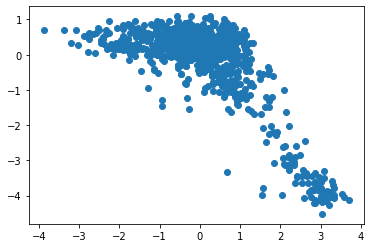

73


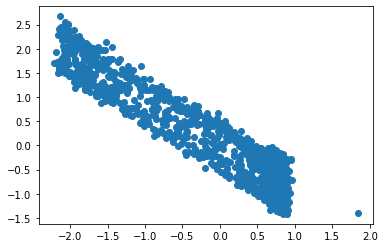

75


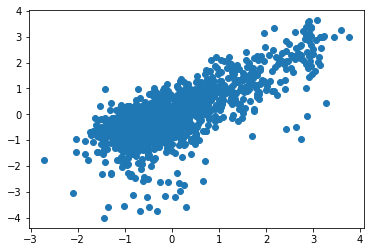

77


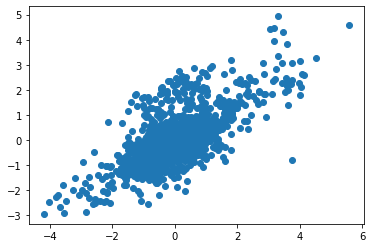

78


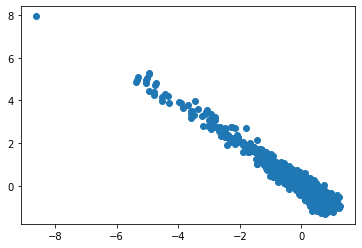

83


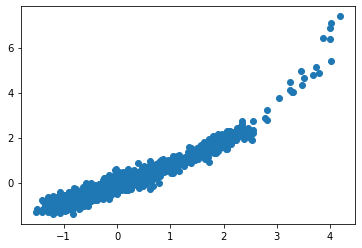

84


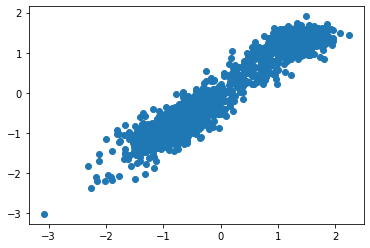

117


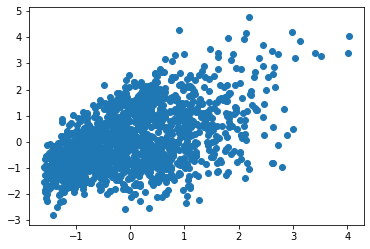

122


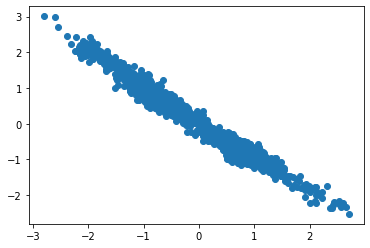

125


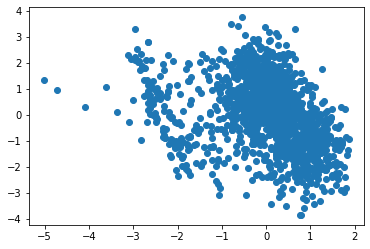

128


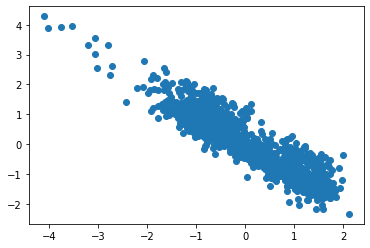

130


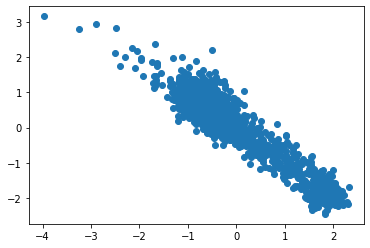

138


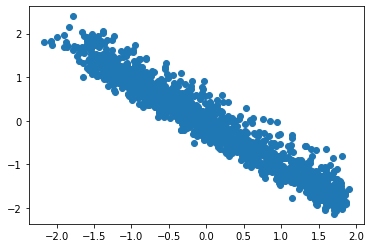

139


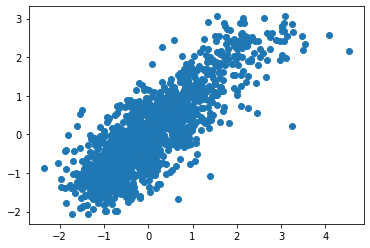

144


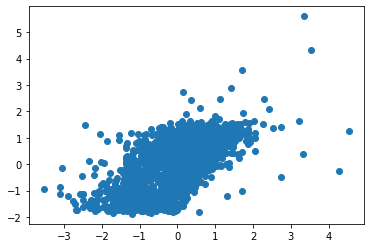

145


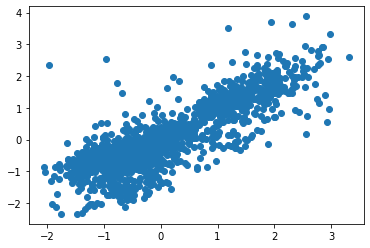

156


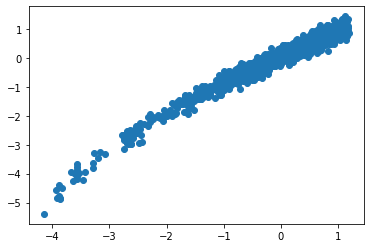

161


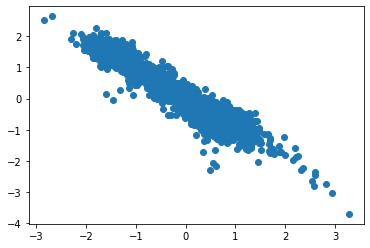

164


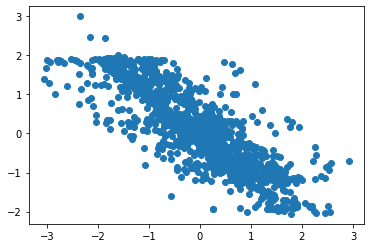

165


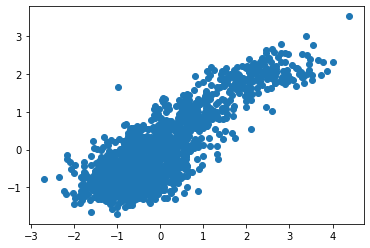

169


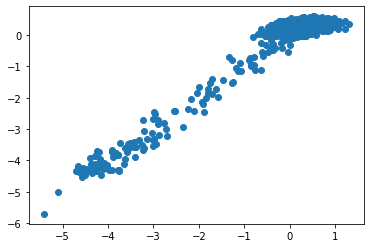

171


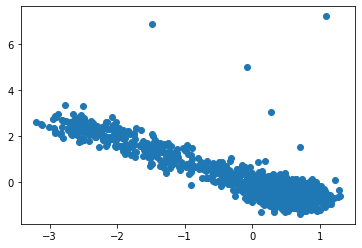

172


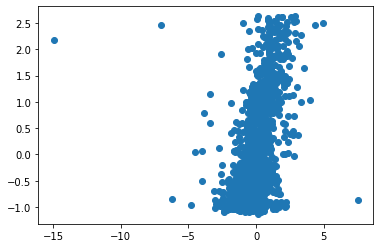

179


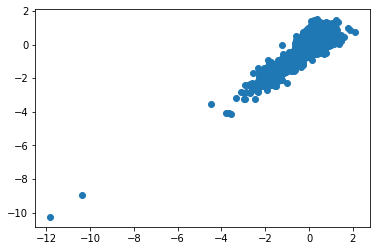

184


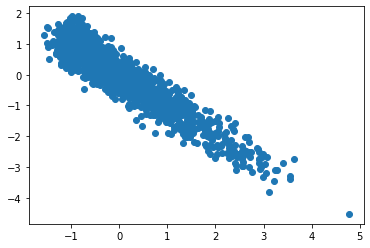

188


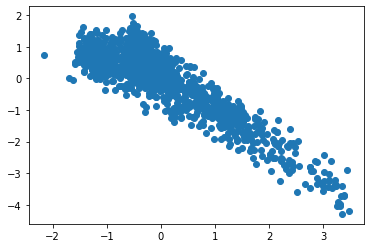

194


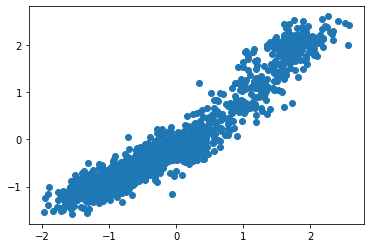

200


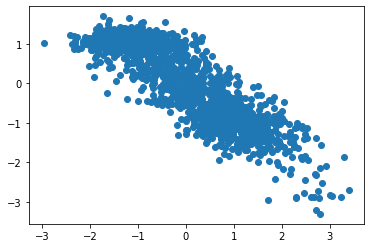

203


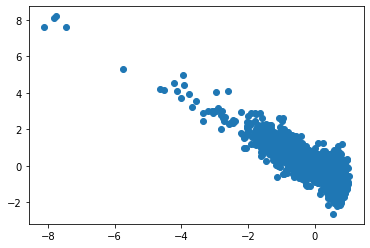

204


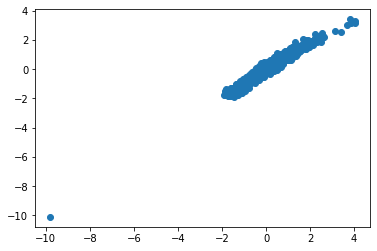

208


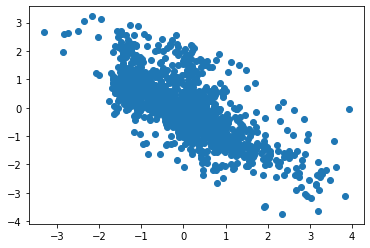

209


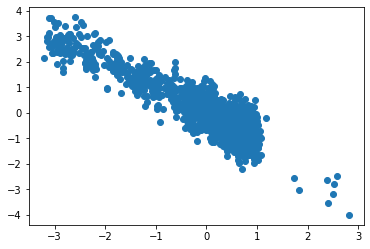

217


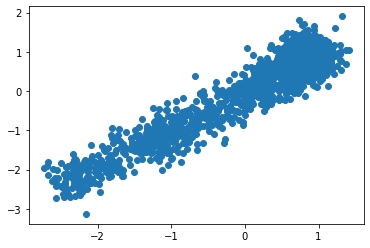

218


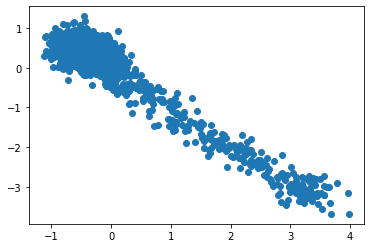

219


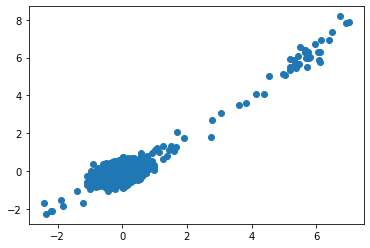

224


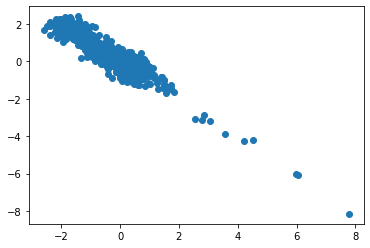

227


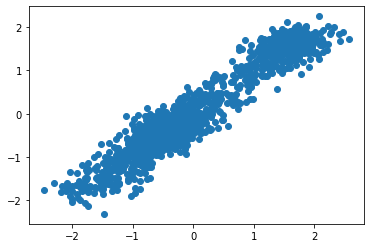

235


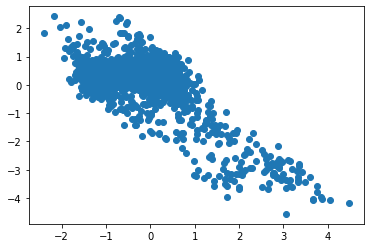

242


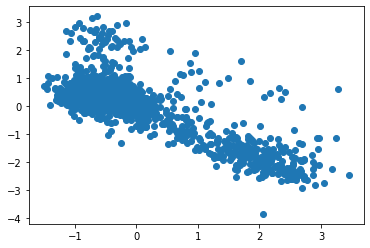

244


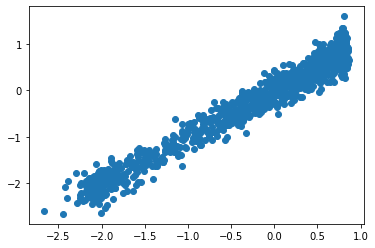

246


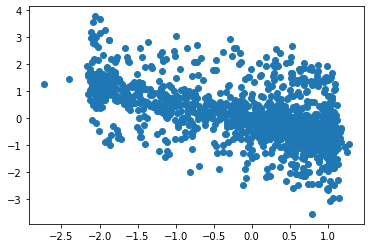

247


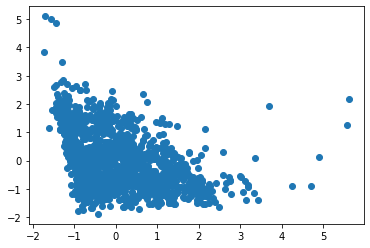

253


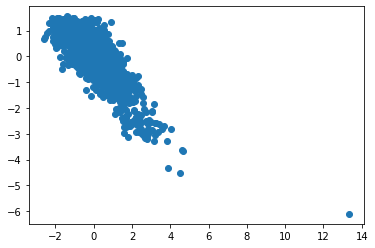

254


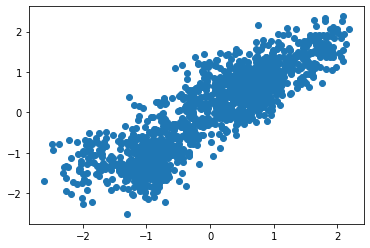

257


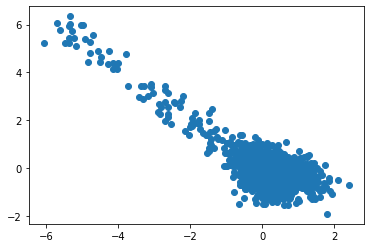

258


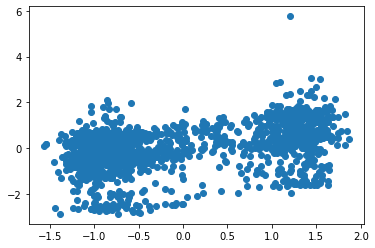

266


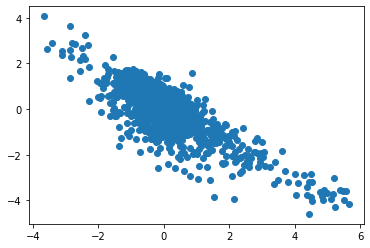

274


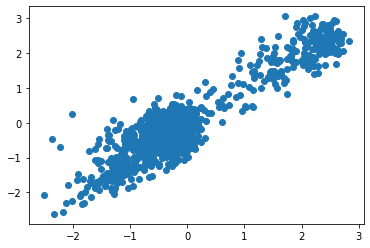

285


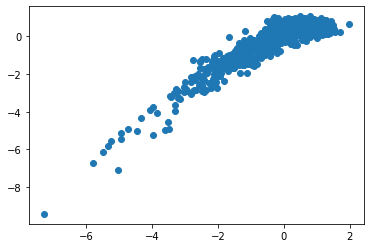

288


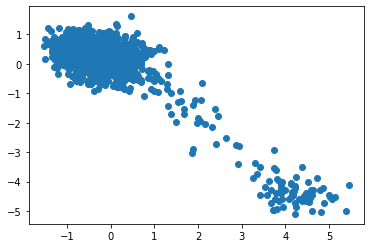

299


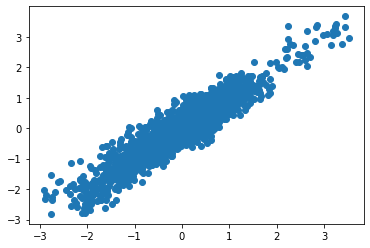

In [20]:
for i in wrong_idx:
    print(i)
    input, output = x[i], y[i]
    plt.scatter(input[:, 0], output[:, 0])
    plt.show()
    plt.close()

# Adam results

In [49]:
import sys
sys.path.append("/vol/bitbucket/ad6013/Research/gp-causal")

In [50]:
data_name = "cha"

In [51]:
import pickle 
import matplotlib.pyplot as plt
import numpy as np



work_dir = "/vol/bitbucket/ad6013/Research/gp-causal"
file_1 = f"fullscore-{data_name}_pairs-gplvm_adam-reinit2-numind200_start:0_end:20.p"
file_2 = f"fullscore-{data_name}_pairs-gplvm_adam-reinit2-numind200_start:20_end:40.p"
file_3 = f"fullscore-{data_name}_pairs-gplvm_adam-reinit2-numind200_start:40_end:60.p"
file_4 = f"fullscore-{data_name}_pairs-gplvm_adam-reinit2-numind200_start:60_end:80.p"
file_5 = f"fullscore-{data_name}_pairs-gplvm_adam-reinit2-numind200_start:80_end:100.p"
file_6 = f"fullscore-{data_name}_pairs-gplvm_adam-reinit2-numind200_start:100_end:120.p"
file_7 = f"fullscore-{data_name}_pairs-gplvm_adam-reinit2-numind200_start:120_end:140.p"
file_8 = f"fullscore-{data_name}_pairs-gplvm_adam-reinit2-numind200_start:140_end:160.p"
file_9 = f"fullscore-{data_name}_pairs-gplvm_adam-reinit2-numind200_start:160_end:180.p"
file_10 = f"fullscore-{data_name}_pairs-gplvm_adam-reinit2-numind200_start:180_end:200.p"
file_11 = f"fullscore-{data_name}_pairs-gplvm_adam-reinit2-numind200_start:200_end:220.p"
file_12 = f"fullscore-{data_name}_pairs-gplvm_adam-reinit2-numind200_start:220_end:240.p"
file_13 = f"fullscore-{data_name}_pairs-gplvm_adam-reinit2-numind200_start:240_end:260.p"
file_14 = f"fullscore-{data_name}_pairs-gplvm_adam-reinit2-numind200_start:260_end:280.p"
file_15 = f"fullscore-{data_name}_pairs-gplvm_adam-reinit2-numind200_start:280_end:300.p"

In [52]:
import importlib
from data import get_data

data_get = getattr(get_data, f"get_{data_name}_pairs_dataset")

x, y, weight, target = data_get(data_path=f"{work_dir}/data/{data_name}_pairs/files")

In [53]:
all_bfgs_cha_scores

{0: ((1242.492654092228, 937.3501643937325),
  (1780.3206693268194, 753.9405411568187)),
 1: ((2031.1930289197403, 904.4779723806632),
  (1928.3609430310416, 1331.9226789242061)),
 2: ((-326.9013134432871, 823.0228547304041),
  (1429.2542140075684, -566.6910731178982)),
 3: ((2101.7764262818077, 1389.2842684029029),
  (1978.4641966949716, 1529.1811871280615)),
 4: ((1835.2166618797532, 1743.2124819958062),
  (2011.1072484509946, 1602.8898671362713)),
 5: ((1001.9551462567379, 1771.2707650402003),
  (2128.407821316394, 591.6732755591471)),
 6: ((1277.6712558473037, 390.1837661319769),
  (1293.014945764915, 248.27267755270225)),
 7: ((488.9657024606595, 1296.8305555300494),
  (1641.8118234479625, 27.620153308060253)),
 8: ((2128.407837799411, 1327.5956549511181),
  (1852.4164772935492, 1636.3505945186316)),
 9: ((-2141.77000315476, 731.5536137146754),
  (1526.9336081234287, -2763.6095705462035)),
 10: ((2119.0352693968116, 1610.0694405430772),
  (2128.4078260825663, 1588.1627427802014)),

In [54]:
y_labels = []
y_scores = []
wrong_idx = []
all_scores = {}
all_causal_scores = {}

for file_idx in range(15):
    with open(f"{work_dir}/results/{eval(f'file_{file_idx + 1}')}", "rb") as f:
        results = pickle.load(f)
        # wrong_idx.extend(results['wrong_idx'])
    for i in range(len(results['scores'])):
        idx = 20 * file_idx + i
        y_label_i = target[idx][0]
        y_labels.append(y_label_i)
        # Calculate the score
        # This is a tuple
        scores = results['scores'][i]
        # bfgs_score = all_bfgs_scores[idx]
        bfgs_score = all_bfgs_cha_scores[idx]
        print(f"Run: {idx}", bfgs_score, scores, '\n')
        causal = min(scores[0][0], bfgs_score[0][0]) + min(scores[0][1], bfgs_score[0][1]) 
        anti_causal =  min(scores[1][0], bfgs_score[1][0]) + min(scores[1][1], bfgs_score[1][1]) 
        # causal = sum(scores[0])
        # anti_causal = sum(scores[1])
        final_score = - causal + anti_causal
        y_scores.append(final_score)
        all_scores[idx] = scores 
        all_causal_scores[idx] = y_label_i * final_score
        if y_label_i * final_score < 0: 
            wrong_idx.append(idx)

Run: 0 ((1242.492654092228, 937.3501643937325), (1780.3206693268194, 753.9405411568187)) ((1349.935918059642, 1199.5702721021291), (1781.4644112634023, 853.2713380160958)) 

Run: 1 ((2031.1930289197403, 904.4779723806632), (1928.3609430310416, 1331.9226789242061)) ((2033.7193702440568, 911.1375250683086), (1928.8992365113072, 1335.939077524165)) 

Run: 2 ((-326.9013134432871, 823.0228547304041), (1429.2542140075684, -566.6910731178982)) ((-194.66841149033644, 832.9662942204038), (1429.8979978029897, 161.82278958156485)) 

Run: 3 ((2101.7764262818077, 1389.2842684029029), (1978.4641966949716, 1529.1811871280615)) ((2101.9045955446622, 1492.9893175171094), (1979.8240966009835, 1529.2635925326028)) 

Run: 4 ((1835.2166618797532, 1743.2124819958062), (2011.1072484509946, 1602.8898671362713)) ((1835.8093300708342, 1748.2101775604488), (2011.5436994378879, 1604.226267714811)) 

Run: 5 ((1001.9551462567379, 1771.2707650402003), (2128.407821316394, 591.6732755591471)) ((1002.967661235647, 1771

In [55]:
all_causal_scores

{0: 354.41839199767765,
 1: 324.61262065484425,
 2: 366.4415996025532,
 3: 16.584689138322574,
 4: 35.56797171170638,
 5: 53.144814421397314,
 6: 126.56739866166345,
 7: 116.36428123468613,
 8: 32.7635790616514,
 9: 234.84999575256325,
 10: 12.534141077121149,
 11: 255.78415565048,
 12: 106.51110305894053,
 13: 32.18578864149549,
 14: 48.50245345258736,
 15: 50.561236709402465,
 16: 28.74438406108402,
 17: -13.485057244252857,
 18: 31.621426024827997,
 19: 11.860892551233519,
 20: 71.57494847382031,
 21: 48.9467267331047,
 22: 24.64940680433847,
 23: 197.93750800989574,
 24: 197.2565940009954,
 25: -2.684606651529066,
 26: -11.10004651333793,
 27: 119.74428555341638,
 28: 135.55570243028387,
 29: 33.456427807599084,
 30: 372.7084347260311,
 31: -56.37815195171697,
 32: -25.375687821742304,
 33: 17.107376386599753,
 34: 128.29949372413103,
 35: 29.824372089874487,
 36: 25.216405463485444,
 37: -12.175270665245534,
 38: 16.026614271667768,
 39: 7.103186460868528,
 40: 1.6265114304360395,

In [56]:
target[244]

array([1.])

In [57]:
all_bfgs_scores[244]

KeyError: 244

In [58]:
all_scores[244]

((2075.5736699509644, 1825.5308535142103),
 (2128.849132538497, 1784.8468645227629))

In [59]:
y_labels = np.array(y_labels)
y_scores = np.array(y_scores)

In [60]:
print(len(y_scores))

298


In [61]:
target[244]

array([1.])

In [62]:
wrong_idx

[17,
 25,
 26,
 31,
 32,
 37,
 45,
 52,
 54,
 60,
 61,
 65,
 66,
 70,
 73,
 79,
 85,
 86,
 90,
 91,
 92,
 95,
 98,
 110,
 117,
 119,
 123,
 124,
 127,
 129,
 130,
 140,
 141,
 150,
 151,
 152,
 153,
 159,
 160,
 171,
 172,
 183,
 186,
 194,
 197,
 199,
 202,
 208,
 209,
 210,
 216,
 217,
 220,
 221,
 224,
 225,
 229,
 230,
 232,
 236,
 237,
 239,
 241,
 245,
 247,
 248,
 250,
 254,
 261,
 263,
 264,
 267,
 275,
 276,
 282,
 286,
 290,
 297]

In [63]:
wrong = []
for i in range(len(y_labels)):
    if y_labels[i] < 0 and y_scores[i] > 0:
        wrong.append(i)
    elif y_labels[i] > 0 and y_scores[i] < 0:
        wrong.append(i)

In [64]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_curve, auc


fpr, tpr, _ = roc_curve(y_labels, y_scores)
roc_auc = auc(fpr, tpr)

In [65]:
roc_auc

0.807224025974026

In [24]:
len(wrong)

51

In [25]:
all_causal_scores

{0: 354.41839199767765,
 1: 324.61262065484425,
 2: 366.4415996025532,
 3: 16.584689138322574,
 4: 35.56797171170638,
 5: 53.144814421397314,
 6: 126.56739866166345,
 7: 116.36428123468613,
 8: 32.7635790616514,
 9: 234.84999575256325,
 10: 12.534141077121149,
 11: 255.78415565048,
 12: 106.51110305894053,
 13: 32.18578864149549,
 14: 48.50245345258736,
 15: 50.561236709402465,
 16: 28.74438406108402,
 17: -13.485057244252857,
 18: 31.621426024827997,
 19: 11.860892551233519,
 20: 71.57494847382031,
 21: 48.9467267331047,
 22: 24.64940680433847,
 23: 197.93750800989574,
 24: 197.2565940009954,
 25: -2.684606651529066,
 26: -11.10004651333793,
 27: 119.74428555341638,
 28: 135.55570243028387,
 29: 33.456427807599084,
 30: 372.7084347260311,
 31: -56.37815195171697,
 32: -25.375687821742304,
 33: 17.107376386599753,
 34: 128.29949372413103,
 35: 29.824372089874487,
 36: 25.216405463485444,
 37: -12.175270665245534,
 38: 16.026614271667768,
 39: 7.103186460868528,
 40: 1.6265114304360395,

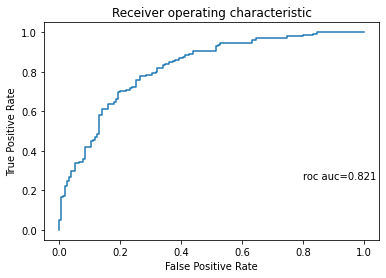

In [23]:
textstr = 'roc auc=%.3f\n'%(
    roc_auc
)
plt.text(0.8, 0.2, textstr, fontsize=10)
plt.plot(
    fpr, tpr
)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.show()

In [30]:
all_scores

{0: ((1349.935918059642, 1199.5702721021291),
  (1781.4644112634023, 853.2713380160958)),
 1: ((2033.7193702440568, 911.1375250683086),
  (1928.8992365113072, 1335.939077524165)),
 2: ((-194.66841149033644, 832.9662942204038),
  (1429.8979978029897, 161.82278958156485)),
 3: ((2101.9045955446622, 1492.9893175171094),
  (1979.8240966009835, 1529.2635925326028)),
 4: ((1835.8093300708342, 1748.2101775604488),
  (2011.5436994378879, 1604.226267714811)),
 5: ((1002.967661235647, 1771.5641324834137),
  (2134.4406036372743, 621.7710679586817)),
 6: ((1280.0448542160138, 424.968228440508),
  (1325.9914580996428, 250.9903104421818)),
 7: ((546.9434174404464, 1302.2274750492597),
  (1664.090888690058, 459.81043703549767)),
 8: ((2132.6441498267905, 1333.1216075502866),
  (1856.7314707159953, 1636.6583186583648)),
 9: ((-1315.596552787369, 670.2440449794221),
  (1528.2488723210217, -2153.698061180544)),
 10: ((2119.052530126619, 1625.294951484293),
  (2134.1748561885224, 1593.9462605499816)),
 1

In [274]:
all_causal_scores

{0: -12.68425835918697,
 1: 283.66388346759413,
 2: 279.8476986515152,
 3: 17.577488871721016,
 4: 45.340885283092575,
 5: 81.93375392412463,
 6: 44.638960178882826,
 7: -6.422488230791259,
 8: 97.74280964908849,
 9: -48.42243418328917,
 10: 12.170416487274451,
 11: 76.97101016803254,
 12: -26.896723144976477,
 13: 35.17496838922011,
 14: 85.85725075597065,
 15: -3.205253318200903,
 16: 139.86758125222832,
 17: 200.86529590273813,
 18: 5.103129466734117,
 19: 112.8287343604602,
 20: 28.689118275823148,
 21: 44.13020776931489,
 22: 63.44613363648568,
 23: -58.97277551197271,
 24: -35.58490640541686,
 25: 107.83760266881518,
 26: 34.007724641342975,
 27: 89.04641620704297,
 28: 11.264985118337336,
 29: 50.80291535373499,
 30: -13.403695507221528,
 31: 368.74059553340976,
 32: 35.98882018755785,
 33: 74.97614417441673,
 34: -12.790401792395642,
 35: 25.505219568277425,
 36: 37.19381102759644,
 37: 45.846401306177086,
 38: 131.68212523652483,
 40: 342.40807634212115,
 41: -10.7837135298505

0


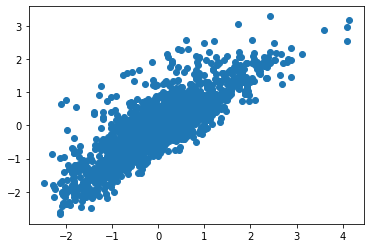

7


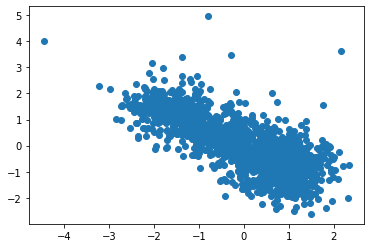

9


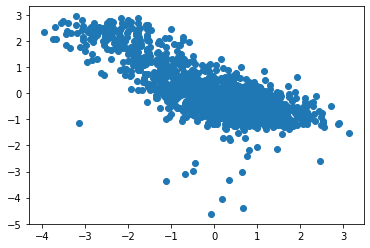

12


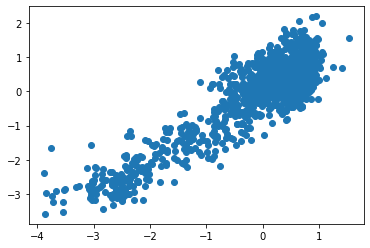

15


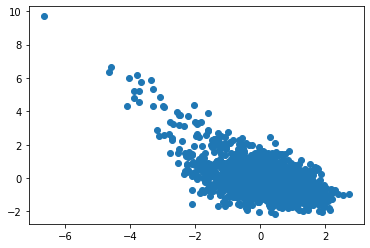

23


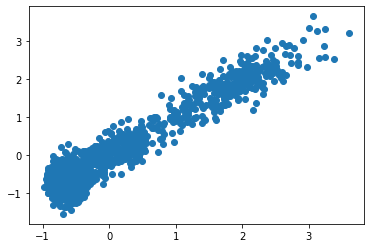

24


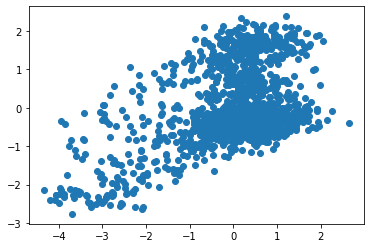

30


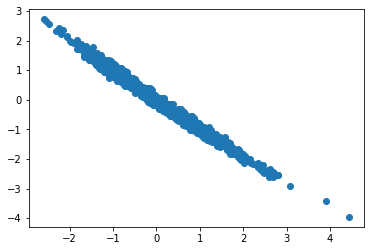

34


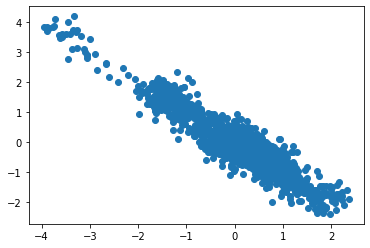

41


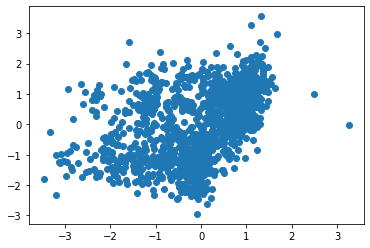

43


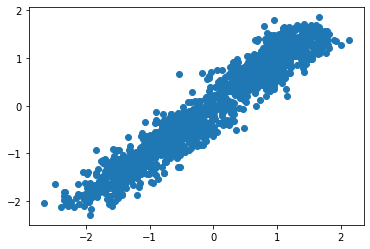

48


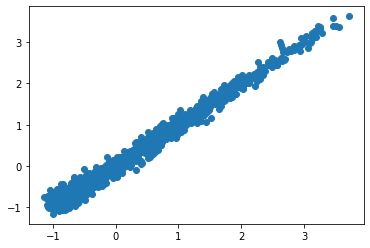

56


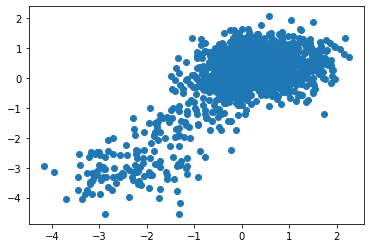

59


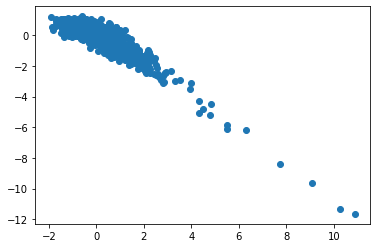

60


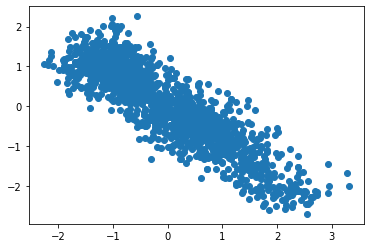

62


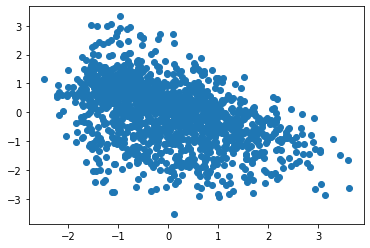

67


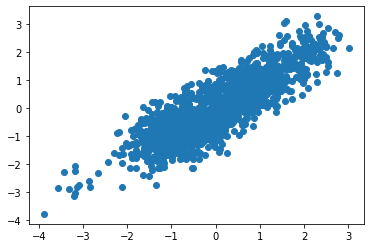

72


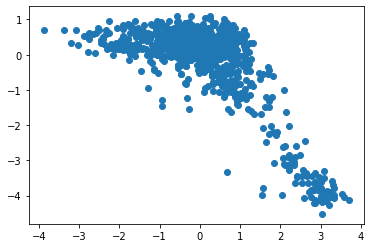

75


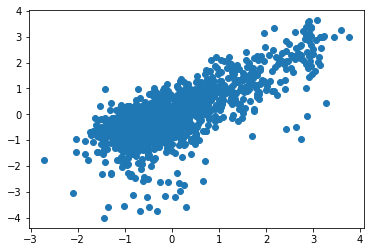

77


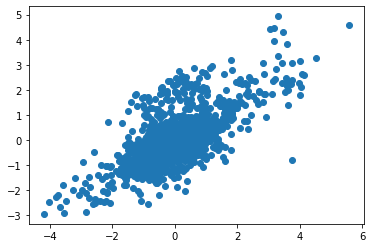

78


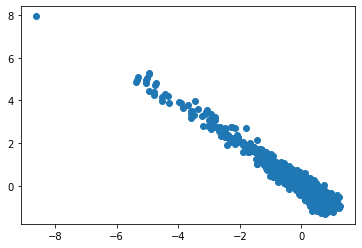

83


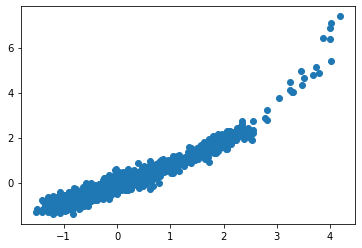

84


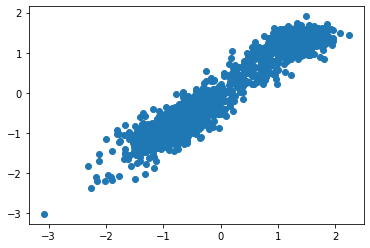

117


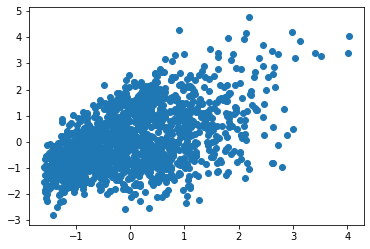

122


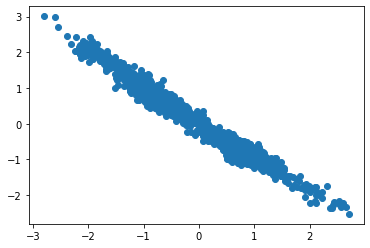

125


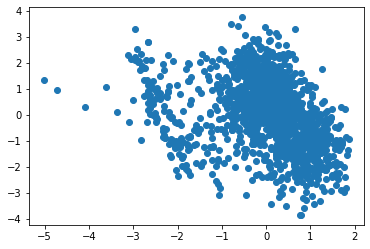

128


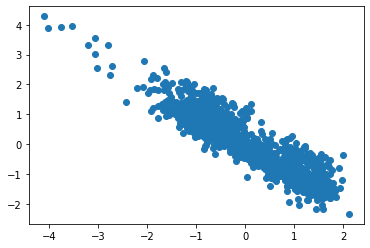

130


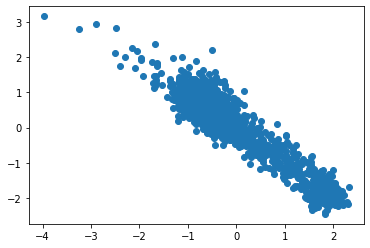

139


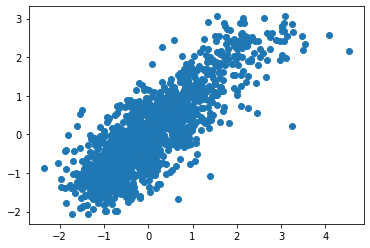

145


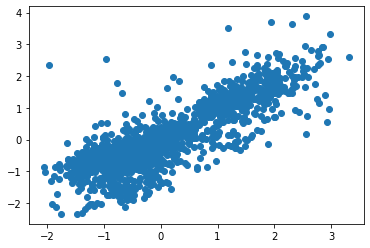

161


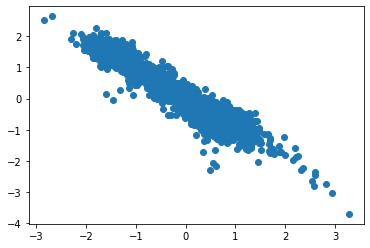

165


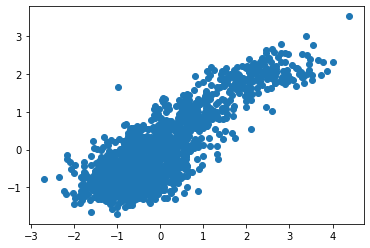

169


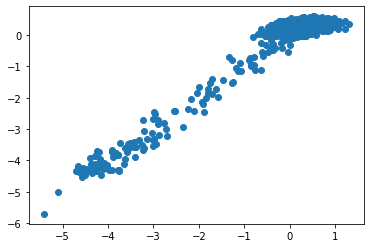

171


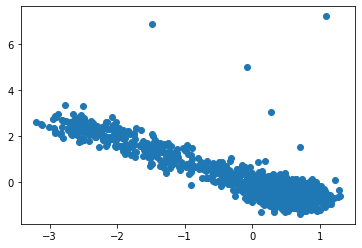

184


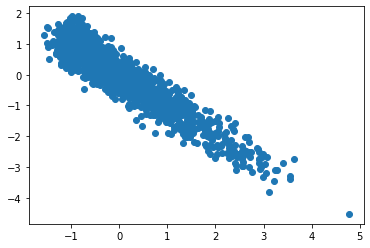

188


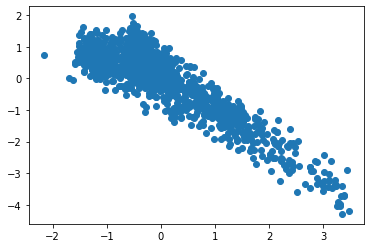

194


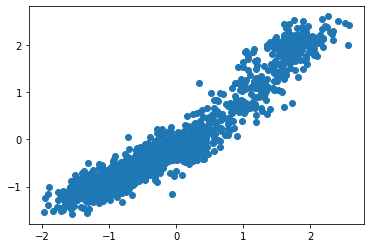

200


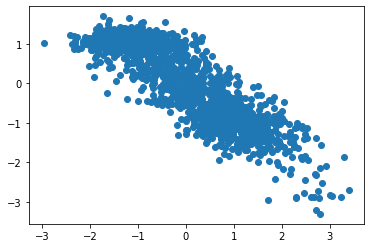

203


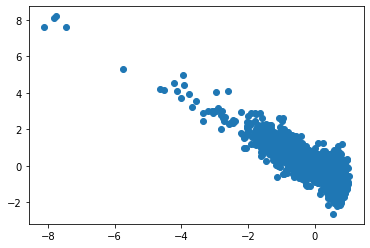

204


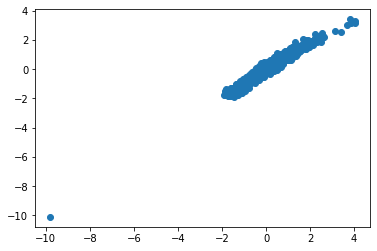

209


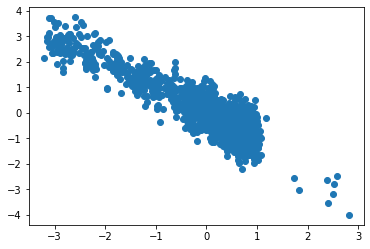

224


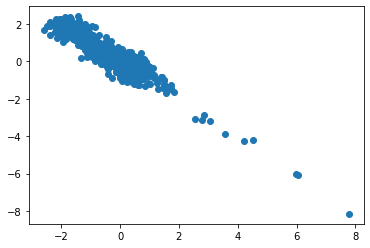

227


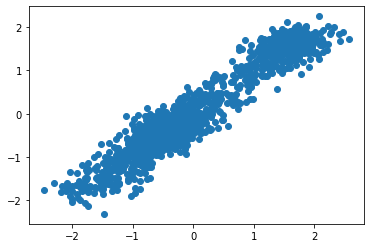

242


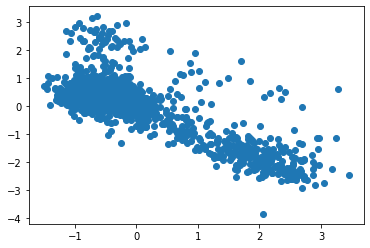

244


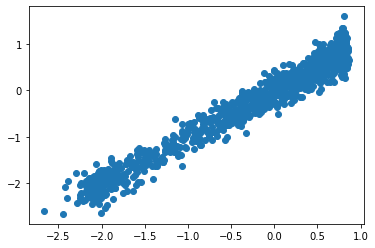

247


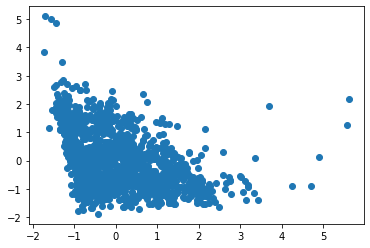

253


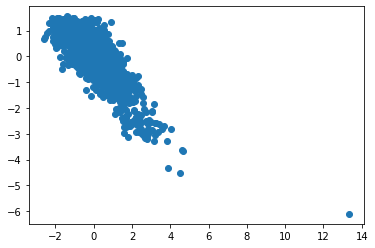

266


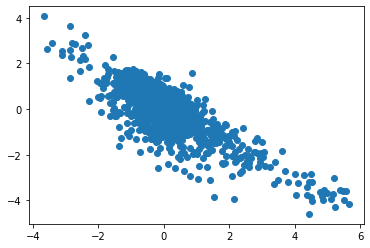

274


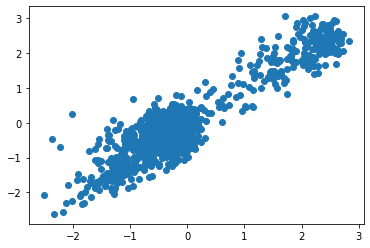

285


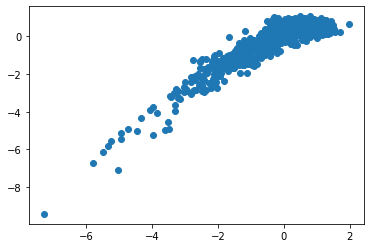

288


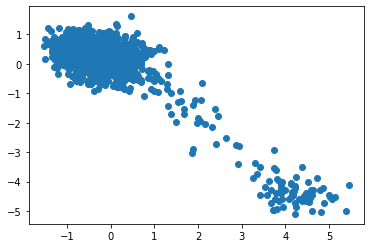

In [275]:
for i in wrong_idx:
    print(i)
    input, output = x[i], y[i]
    plt.scatter(input[:, 0], output[:, 0])
    plt.show()
    plt.close()

In [1]:
import sys
sys.path.append("/vol/bitbucket/ad6013/Research/gp-causal")

In [2]:
import pickle
import numpy as np

with open('/vol/bitbucket/ad6013/Research/gp-causal/results/fullscore-cep-gplvm-sqexp-reinit20.p', 'rb') as f:
    results = pickle.load(f)

In [3]:
results["wrong_idx"]

[2, 11, 14, 15, 16, 20, 21, 25, 26, 27, 36, 38, 39, 40]

In [5]:
res = results['scores']

In [12]:
res[40]

((853.2037779970747, 1058.2230798927458),
 (1060.9003573842128, 828.3835483833768))

In [21]:
sum(res[0])

TypeError: unsupported operand type(s) for +: 'int' and 'tuple'

In [26]:
y_scores = np.zeros(len(res))
for i in range(len(res)):
    causal_score = - sum(res[i][0]) + sum(res[i][1])
    y_scores[i] = causal_score

In [30]:
y_scores[0:20] = -1 * y_scores[0:20] 

In [32]:
y_labels = np.ones(43)
y_labels[0:20] = -1 * y_labels[0:20]

In [33]:
y_labels

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.])

In [36]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_curve, auc


fpr, tpr, _ = roc_curve(y_labels, y_scores)
roc_auc = auc(fpr, tpr)

In [37]:
roc_auc

0.7217391304347827